In [1]:
#%% Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nets_predict.classes.hmm import HiddenMarkovModelClass
from nets_predict.classes.partial_correlation import PartialCorrelationClass
import matplotlib.cm as cm
import pandas as pd

HMMClass = HiddenMarkovModelClass()
PartialCorrClass = PartialCorrelationClass()


/users/win-fmrib-analysis/psz102/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
# set parameters for script
n_chunk = 4
n_ICs = 25
n_edge = int((n_ICs * (n_ICs - 1))/2)

In [78]:
# set project directories
proj_dir = '/gpfs3/well/win-fmrib-analysis/users/psz102/nets_project/nets_predict'
load_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"

# decide which featured to examine
feature_prediction_dict = dict()
feature_prediction_dict['static_icov_icov'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_states_0_model_mean_True.npz")
feature_prediction_dict['actual_icov_icov'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['actual_icov_cov'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_cov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['actual_cov_icov'] = np.load(f"{load_dir}/edge_prediction_all_nm_cov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['actual_cov_cov'] = np.load(f"{load_dir}/edge_prediction_all_nm_cov_pm_cov_chunks_{n_chunk}_features_used_actual.npz")


In [79]:
# load ground truth matrix
ground_truth_dir = f"{proj_dir}/results/ICA_{n_ICs}/ground_truth"
ground_truth_matrix = np.load(f"{ground_truth_dir}/ground_truth_partial_mean_4_sessions.npy")

# extract upper diagonal (excluding main diagonal) 
ground_truth_icov_reshape = PartialCorrClass.extract_upper_off_main_diag(ground_truth_matrix)

# take mean ground truth across subjects
ground_truth_icov_reshape_mean = np.mean(ground_truth_icov_reshape,axis=0)


5
static_icov_icov actual_icov_icov actual_icov_cov actual_cov_icov actual_cov_cov
alpha l1_ratio corr_y predict_y beta accuracy_per_edge


/tmp/ipykernel_304830/4181716632.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('twilight_shifted')


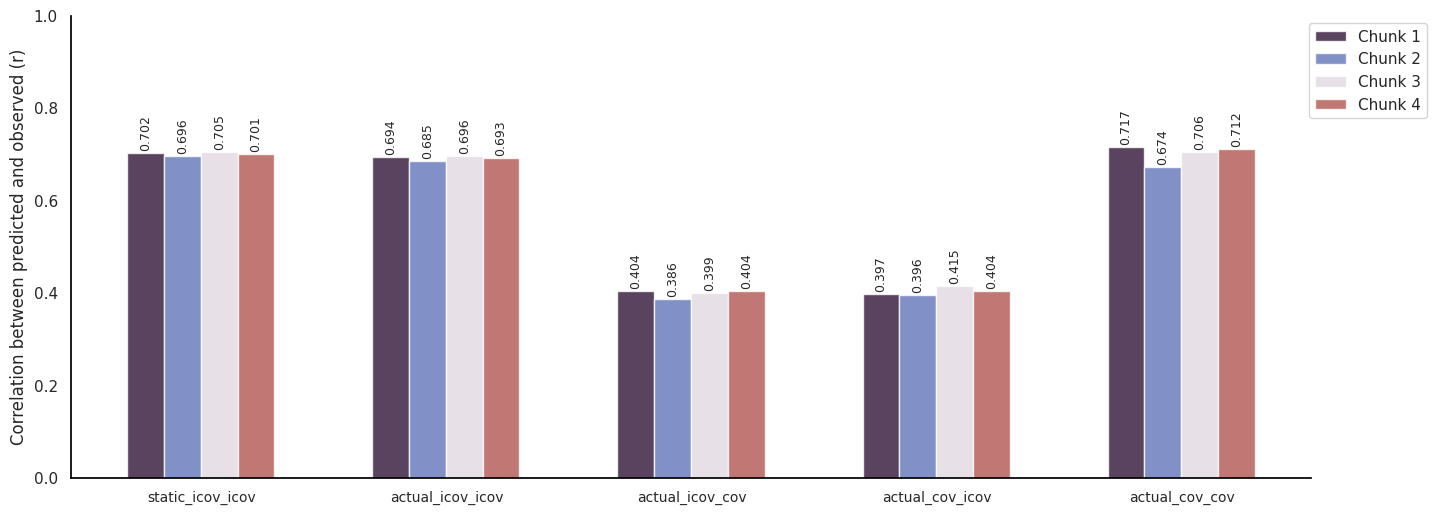

In [80]:
###################### let's compare partial correlations with full covariances (predictOR and predictED) ######################

# note how many dynamic features are being used and print what they are
n_feat_type = len(feature_prediction_dict) 
print(n_feat_type)
print(*feature_prediction_dict)

# let's combine the prediction accuracies for each hmm features into a combined array
hmm_features_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
feat_num = 0
labels = []
for key, value in feature_prediction_dict.items():
    hmm_features_accuracy[feat_num,:,:] = value['accuracy_per_edge']
    labels.append(key) # create labels for plot
    feat_num += 1
    
    
print(*feature_prediction_dict['static_icov_icov'])

# if we want to remove nan subjects see commented code at end of script

# Here we split up the accuracy of the chunks for using partial correlations to predict partial correlations
# Create a colormap with a smooth transition of colors
cmap = cm.get_cmap('twilight_shifted')

# Define the number of colors needed
num_colors = n_chunk

# Get a list of colors from the colormap
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a new figure for the grouped bar chart with a larger size
fig, ax = plt.subplots(figsize=(16, 6))

# Set bar width, group offset, and x-positions of bars
x = np.arange(len(labels))
if n_chunk == 4:
    bar_width = 0.15
    group_offset = (len(labels)) * bar_width
elif n_chunk == 12:
    bar_width = 0.05
    group_offset = (len(labels) + 8) * bar_width

# Iterate over the traits
for i in range(n_chunk):
    chunk_plot = hmm_features_accuracy[:,i,:]

    # Calculate the mean values for each bar
    means = np.mean(chunk_plot, axis=1)

    # Calculate the x-axis positions for the bars within a group
    x_grouped = x + (i - 2) * bar_width - group_offset + 0.37

    # Plot the bars within a group
    bars = ax.bar(x_grouped, means, width=bar_width, color=colors[i % num_colors], alpha=0.8)

    # Add text labels on top of each bar with decreased fontsize
    for bar in bars:
        height = bar.get_height()
        if n_chunk == 4:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=9, rotation=90)
        elif n_chunk == 12:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=6, rotation=90)

# Set the y-axis label
ax.set_ylabel('Correlation between predicted and observed (r)', fontsize=12)

# Set the x-axis tick labels and move them to the left
if n_chunk == 4:
    ax.set_xticks(x - 0.45)
elif n_chunk == 12:
    ax.set_xticks(x - 0.25)

ax.set_xticklabels(labels, fontsize=10)

# Add a legend for the eight bars
ax.legend(labels=['Chunk ' + str(i+1) for i in range(n_chunk)], loc='upper right', bbox_to_anchor=(1.1, 1.0))

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the y-axis limits to range from 0.7 to 1
ax.set_ylim(0, 1)
#ax.set_ylim(np.nanmin(means)-0.05, np.nanmax(means)+0.1)

# Remove the grid
ax.grid(False)

# Set the color of the x and y axis lines to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Show the plot
plt.show()

5
(1200,)


/tmp/ipykernel_304830/268557528.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_304830/268557528.py:23: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_304830/268557528.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


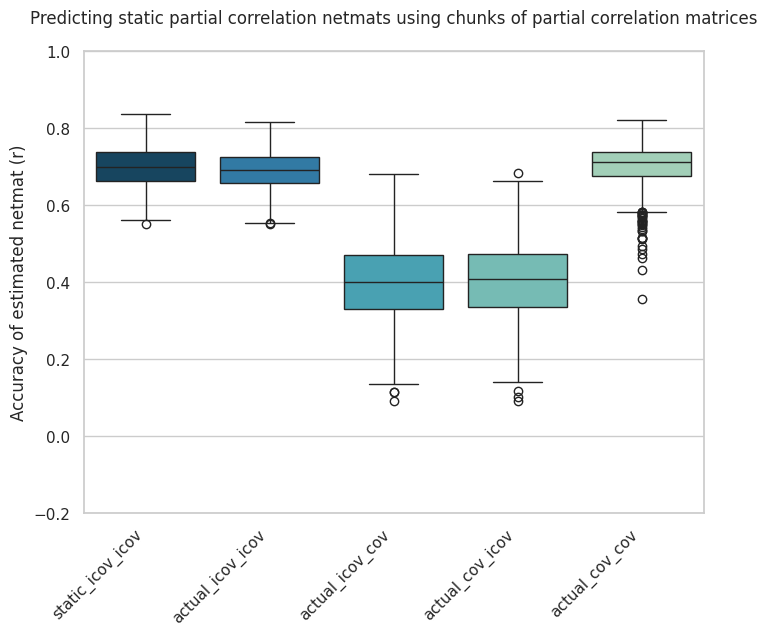

In [81]:
##################### Plot box plots of accuracies across HMM feature groups (across edges)  ########################

# transform array to list to make dataframe to pot as boxplots across edges
hmm_features_accuracy_list = []

for j in range(n_feat_type):
    hmm_features_accuracy_list.append(hmm_features_accuracy[j,:,:].flatten())

print(len(hmm_features_accuracy_list))
print(hmm_features_accuracy_list[0].shape)


# Create a dataframe with the data and group names
df = pd.DataFrame({'Group': np.repeat(labels, [hmm_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
                   'Value': np.concatenate(hmm_features_accuracy_list)})

# Create the grouped boxplot using Seaborn
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd', '#9ad6b8', '#c8e9b3', '#e1f5ca']
#colors = ['#0B486B', '#6bc6bd']
sns.set(style="whitegrid")
#sns.set(style="white")
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('')
plt.ylabel('Accuracy of estimated netmat (r)')

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ymin = -0.2  # Minimum y-value
ymax = 1  # Maximum y-value
ax.set_ylim(ymin, ymax)


# Set the title
plt.title("Predicting static partial correlation netmats using chunks of partial correlation matrices", fontsize=12, pad=20)

# Show the plot
plt.show()

In [82]:
# now load ???
static_dir = f"{proj_dir}/results/ICA_{n_ICs}/static"
partial_correlations_chunk = np.load(f"{static_dir}/partial_correlations_{n_chunk}_chunks.npy")
print(partial_correlations_chunk.shape)
partial_correlations_chunk_flatten = PartialCorrClass.extract_upper_off_main_diag(partial_correlations_chunk)
print(partial_correlations_chunk_flatten.shape)

predicted_edges_static = feature_prediction_dict['static_icov_icov']['predict_y']
print(partial_correlations_chunk_flatten.shape)
static_chunk_actual_flatten_mean = np.mean(partial_correlations_chunk_flatten, axis=0)
print(static_chunk_actual_flatten_mean.shape)
print(predicted_edges_static.shape)
predicted_edges_static_mean = np.mean(predicted_edges_static, axis=1)
print(predicted_edges_static_mean.shape)

print(ground_truth_icov_reshape_mean.shape)
ground_truth_icov_reshape_mean = ground_truth_icov_reshape_mean[0:n_edge]
print(ground_truth_icov_reshape_mean.shape)
print(static_chunk_actual_flatten_mean.shape)
static_chunk_actual_flatten_mean = static_chunk_actual_flatten_mean[:,0:n_edge]
print(static_chunk_actual_flatten_mean.shape)

(1003, 4, 25, 25)
(1003, 4, 300)
(1003, 4, 300)
(4, 300)
(4, 1003, 300)
(4, 300)
(300,)
(300,)
(4, 300)
(4, 300)


In [83]:
# find the difference between the prediction and the ground truth for both the 'prediction' and 'actual' version
static_prediction_MSE = (predicted_edges_static_mean[1,:] - ground_truth_icov_reshape_mean)**2
static_actual_MSE = (static_chunk_actual_flatten_mean[1,:] - ground_truth_icov_reshape_mean)**2
static_prediction_ASE = np.abs((predicted_edges_static_mean[1,:] - ground_truth_icov_reshape_mean))
static_actual_ASE = np.abs((static_chunk_actual_flatten_mean[1,:] - ground_truth_icov_reshape_mean))

# find the difference between the 'prediction' MSE and the 'actual' MSE
prediction_actual_MSE_diff = (static_actual_MSE - static_prediction_MSE)
prediction_actual_ASE_diff = (static_actual_ASE - static_prediction_ASE)

#print(predicted_edges_static_mean.shape)
print(static_chunk_actual_flatten_mean.shape)
print(np.nansum(static_prediction_MSE)) # prediction is MUCH better than the 'actual'
print(np.nansum(static_actual_MSE))

# turn into a 25 x 25 matrix in order to plot more nicely
MSEs_array = np.zeros((3, n_ICs, n_ICs))
m, n = np.triu_indices(n_ICs, 1)
MSEs_array[0, m, n] = static_actual_MSE 
MSEs_array[0, n, m] = static_actual_MSE 
MSEs_array[1, m, n] = static_prediction_MSE 
MSEs_array[1, n, m] = static_prediction_MSE 
MSEs_array[2, m, n] = prediction_actual_MSE_diff 
MSEs_array[2, n, m] = prediction_actual_MSE_diff 

ASEs_array = np.zeros((3, n_ICs, n_ICs))
m, n = np.triu_indices(n_ICs, 1)
ASEs_array[0, m, n] = static_actual_ASE 
ASEs_array[0, n, m] = static_actual_ASE 
ASEs_array[1, m, n] = static_prediction_ASE 
ASEs_array[1, n, m] = static_prediction_ASE 
ASEs_array[2, m, n] = prediction_actual_ASE_diff 
ASEs_array[2, n, m] = prediction_actual_ASE_diff 

(4, 300)
0.001016507047945133
10.429207156474499


In [84]:
# Define the brain networks
if n_ICs == 25:
    brain_networks = ['VIS', 'VIS', 'VIS', 'DM', 'FP', 'VAT', 'DM', 'DM', 'VIS', 'FP',
                    'FP', 'ATT', 'SSM', 'VIS', 'AUD', 'DAT', 'EC', 'ATT', 'DM',
                    'EC', 'SSM', 'CB', 'SN', 'THAL', 'BG']
elif n_ICs == 50:
    brain_networks = ['VIS', 'VIS', 'VIS', 'DM', 'FP', 'VAT', 'DM', 'DM', 'VIS', 'FP',
                    'FP', 'ATT', 'SSM', 'VIS', 'AUD', 'DAT', 'EC', 'ATT', 'DM',
                    'EC', 'SSM', 'CB', 'SN', 'THAL', 'BG',
                    'VIS', 'VIS', 'VIS', 'DM', 'FP', 'VAT', 'DM', 'DM', 'VIS', 'FP',
                    'FP', 'ATT', 'SSM', 'VIS', 'AUD', 'DAT', 'EC', 'ATT', 'DM',
                    'EC', 'SSM', 'CB', 'SN', 'THAL', 'BG']


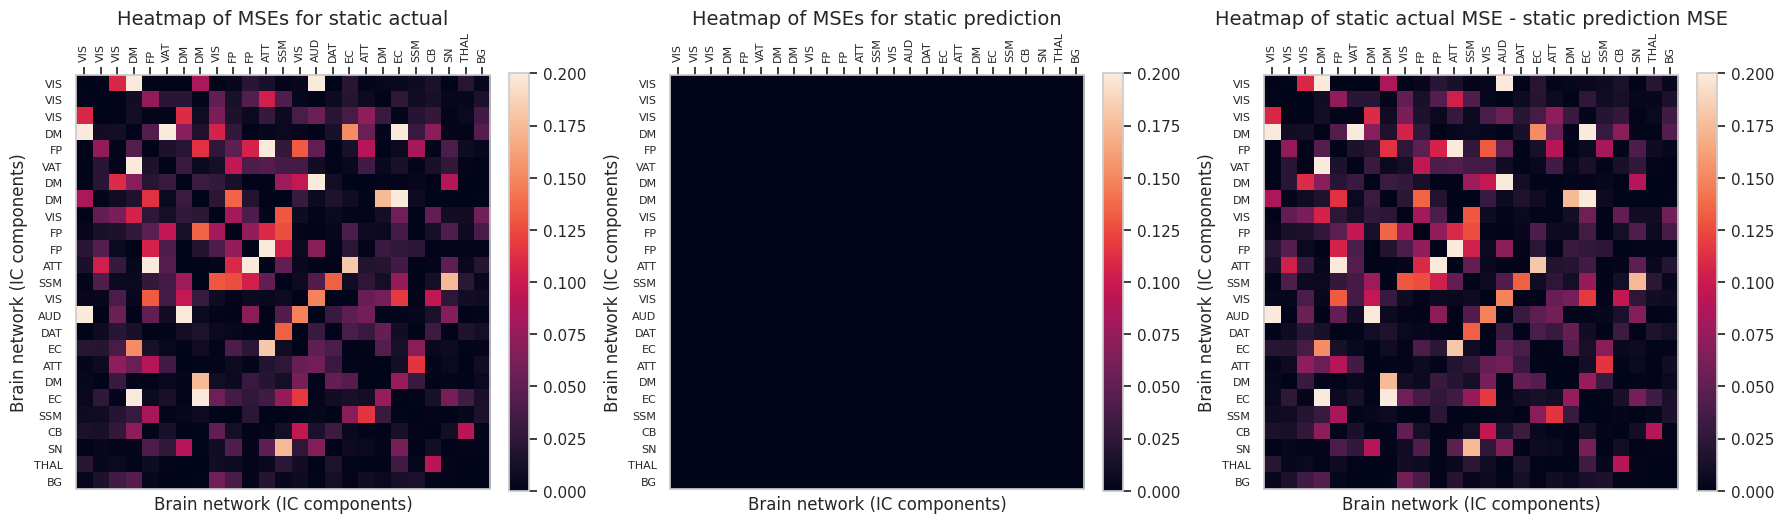

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

titles = [
    "Heatmap of MSEs for static actual",
    "Heatmap of MSEs for static prediction",
    "Heatmap of static actual MSE - static prediction MSE"
]

for i in range(3):
    # Create the heatmap
    heatmap = axs[i].imshow(MSEs_array[i,:,:], vmin = 0, vmax = 0.2, cmap='rocket')

    # Remove the grey grid lines
    axs[i].grid(False)

    # Add a colorbar
    cbar = fig.colorbar(heatmap, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)

    # Set the x-axis and y-axis labels as "Brain networks"
    axs[i].set_xlabel("Brain network (IC components)", fontsize=12)
    axs[i].set_ylabel("Brain network (IC components)", fontsize=12)

    # Set the x-axis and y-axis tick positions and labels
    axs[i].set_xticks(range(n_ICs))
    axs[i].set_yticks(range(n_ICs))
    axs[i].set_xticklabels(brain_networks, fontsize=8, rotation=90)
    axs[i].set_yticklabels(brain_networks, fontsize=8)

    # Move the x-axis tick labels to the top
    axs[i].xaxis.set_ticks_position('top')

    # Set the title
    axs[i].set_title(titles[i], fontsize=14)

# Adjust layout to make room for the colorbars
plt.tight_layout()
plt.show()

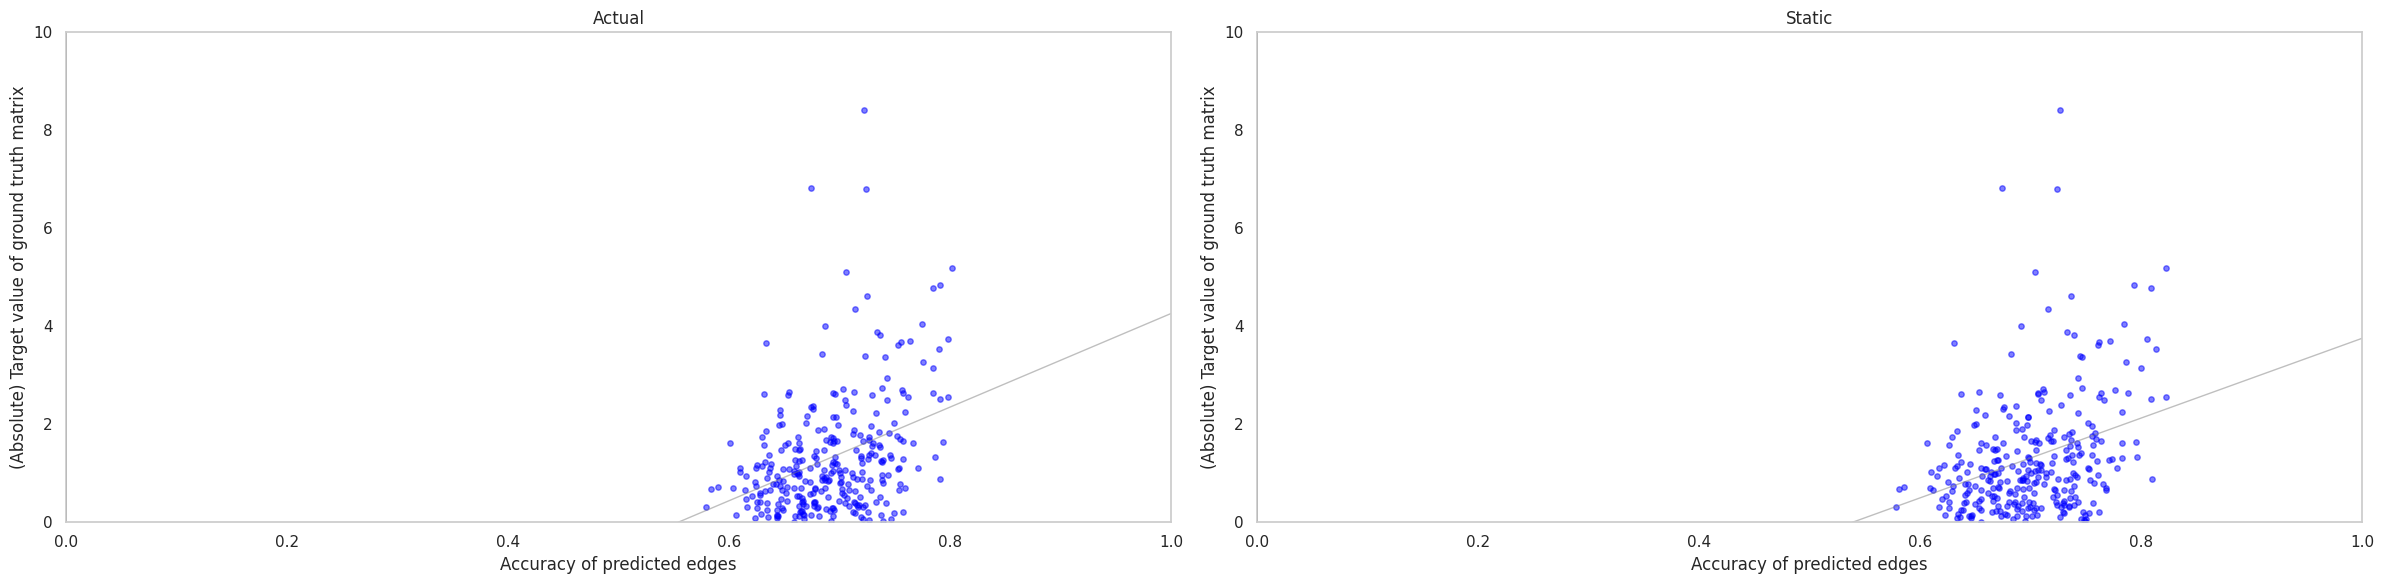

In [86]:
# Assuming feature_prediction_dict and ground_truth_icov_reshape_mean are already defined

# Define the different x datasets
x_actual = np.mean(feature_prediction_dict['actual_icov_icov']['accuracy_per_edge'], axis=0)
x_static = np.mean(feature_prediction_dict['static_icov_icov']['accuracy_per_edge'], axis=0)
#x_fc = np.mean(feature_prediction_dict['fc']['accuracy_per_edge'], axis=0)


y = np.abs(ground_truth_icov_reshape_mean)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))  # 1 row, 3 columns

# List of x datasets and titles for each subplot
x_data = [x_actual, x_static]#, x_fc]
titles = ['Actual', 'Static']#, 'FC']

for ax, x, title in zip(axes, x_data, titles):
    # Create the scatter plot
    ax.scatter(x, y, color='blue', alpha=0.5, s=15)  # Set the color and transparency

    # Add black lines on x and y axes
    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line at x=0

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel('Accuracy of predicted edges')
    ax.set_ylabel('(Absolute) Target value of ground truth matrix')

    # Set axes limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 10])

    # Hide the grid
    ax.grid(False)

    # Fit linear regression via least squares with numpy.polyfit
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 10
    xseq = np.linspace(0, 10, num=100)

    #ax.axvline(x=0.6, color='black', linestyle='-', linewidth=3)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color="grey", lw=1, alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


dict_keys(['static_icov_icov', 'actual_icov_icov', 'actual_icov_cov', 'actual_cov_icov', 'actual_cov_cov'])
(4, 300)
(4, 300)
(3, 25, 25)
(3, 300)
(300,)


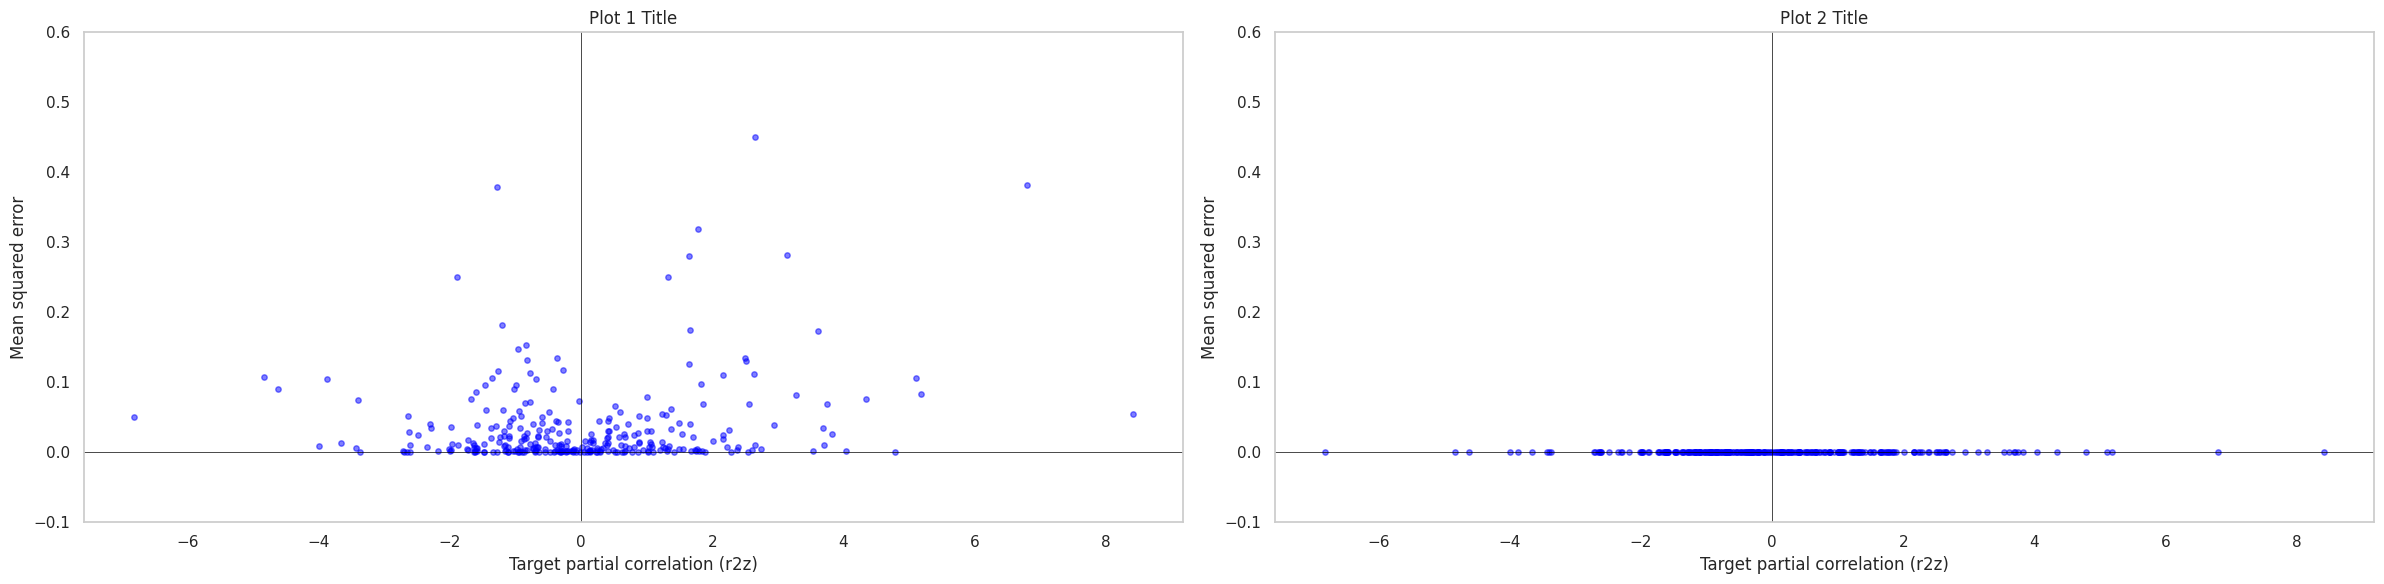

In [89]:
# Assuming MSEs_array_reshape and ground_truth_icov_reshape_mean are defined as in your code
print(feature_prediction_dict.keys())
print(feature_prediction_dict['static_icov_icov']['accuracy_per_edge'].shape)
print(feature_prediction_dict['actual_icov_icov']['accuracy_per_edge'].shape)
print(MSEs_array.shape)
MSEs_array_reshape = MSEs_array[..., m, n]  # flatten covs
ASEs_array_reshape = ASEs_array[..., m, n]  # flatten covs
print(MSEs_array_reshape.shape)
print(ground_truth_icov_reshape_mean.shape)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))  # 1 row, 3 columns

for j in range(2):
    x = ground_truth_icov_reshape_mean
    y = MSEs_array_reshape[j, :]

    # Create the scatter plot in the j-th subplot
    ax = axes[j]
    ax.scatter(x, y, color='blue', alpha=0.5, s=15)  # Set the color and transparency

    # Add black lines on x and y axes
    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line at x=0

    # Set plot title and labels
    ax.set_xlabel('Target partial correlation (r2z)')
    ax.set_ylabel('Mean squared error')
    ax.grid(False)  # Hide the grid

    # Set the y-axis limits
    ax.set_ylim(-0.1, 0.6)

    if j == 0:
        ax.set_title("Plot 1 Title")  # Replace with appropriate title
    elif j == 1:
        ax.set_title("Plot 2 Title")  # Replace with appropriate title
    elif j == 2:
        ax.set_title("Plot 3 Title")  # Replace with appropriate title

# Show the figure
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

(4, 10, 300, 300)
(300,)


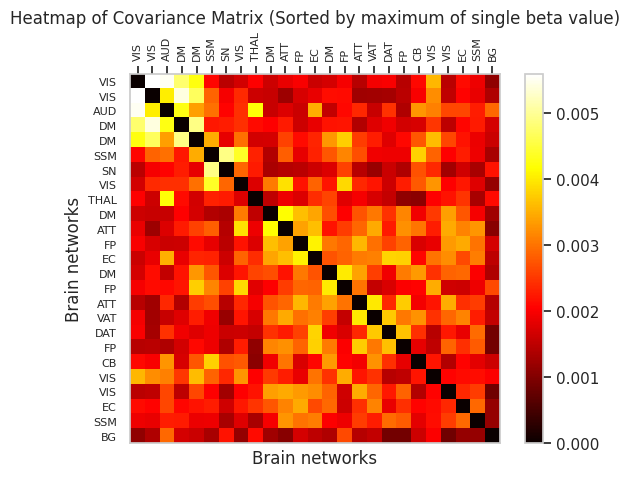

In [90]:
################### Heatmap of betas for static predictions ###################

# note betas then reshape for plot
betas_static = feature_prediction_dict['static_icov_icov']['beta']
print(betas_static.shape)
betas_static_mean = np.mean(np.mean(np.mean(betas_static, axis = 0), axis = 0), axis = 0)
print(betas_static_mean.shape)
betas_static_mean_reshape = np.zeros((n_ICs, n_ICs))
m, n = np.triu_indices(n_ICs, 1)
betas_static_mean_reshape[m, n] = betas_static_mean
betas_static_mean_reshape[n, m] = betas_static_mean

# Calculate the maximum values of each row
row_max_values = np.max(betas_static_mean_reshape, axis=1)

# Get the sorting indices based on the maximum values
sorting_indices = np.argsort(row_max_values)[::-1]

# Reorder the covariance matrix and brain networks based on the sorting indices
betas_static_mean_reshape_sorted = betas_static_mean_reshape[sorting_indices][:, sorting_indices]
brain_networks_sorted = [brain_networks[i] for i in sorting_indices]

# Create a new figure
fig, ax = plt.subplots()

# Create the heatmap
heatmap = ax.imshow(betas_static_mean_reshape_sorted, cmap='hot')

# Remove the grey grid lines
ax.grid(False)

# Add a colorbar
cbar = plt.colorbar(heatmap)

# Set the x-axis and y-axis labels as "Brain networks"
ax.set_xlabel("Brain networks", fontsize=12)
ax.set_ylabel("Brain networks", fontsize=12)

# Set the x-axis and y-axis tick positions and labels
ax.set_xticks(range(n_ICs))
ax.set_yticks(range(n_ICs))
ax.set_xticklabels(brain_networks_sorted, fontsize=8, rotation=90)
ax.set_yticklabels(brain_networks_sorted, fontsize=8)

# Move the x-axis tick labels to the top
ax.xaxis.set_ticks_position('top')

# Set the title
plt.title("Heatmap of Covariance Matrix (Sorted by maximum of single beta value)")

# Show the figure
plt.show()

In [91]:
print(static_chunk_actual_flatten_mean.shape)
print(predicted_edges_static_mean.shape)
#print(predicted_edges_fc_mean.shape)

(4, 300)
(4, 300)


In [92]:
# # interleave columns of data and then remove NaNs
accuracy_per_edge = predicted_edges_static_mean
accuracy_per_edge_actual_1 = static_chunk_actual_flatten_mean


row_a, col_a = np.shape(accuracy_per_edge_actual_1)
row_b, col_b = np.shape(accuracy_per_edge)
accuracy_interleave = np.ravel([accuracy_per_edge_actual_1, accuracy_per_edge],order="F").reshape(col_a,row_a+row_b).T
print(accuracy_interleave.shape)
accuracy_interleave_clean = accuracy_interleave[:, ~np.isnan(accuracy_interleave).any(axis=0)]
print(accuracy_interleave_clean.shape)

(8, 300)
(8, 300)


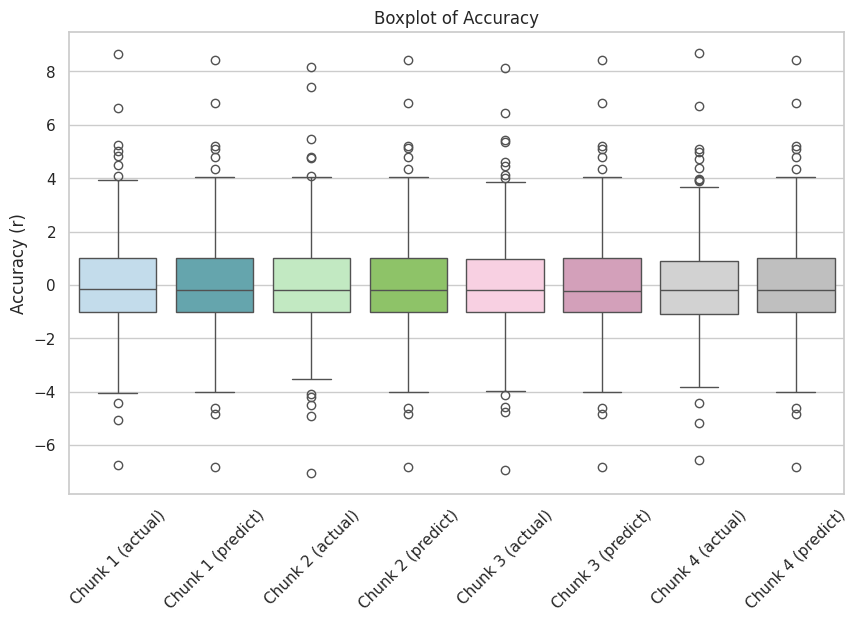

In [93]:
# Assuming you have accuracy_interleave defined

# Create labels for the boxplot
if n_chunk == 4:
    labels = ['Chunk 1 (actual)','Chunk 1 (predict)','Chunk 2 (actual)','Chunk 2 (predict)','Chunk 3 (actual)','Chunk 3 (predict)','Chunk 4 (actual)','Chunk 4 (predict)']
elif n_chunk == 12:
    labels = ['Chunk 1 (actual)','Chunk 1 (predict)','Chunk 2 (actual)','Chunk 2 (predict)','Chunk 3 (actual)','Chunk 3 (predict)','Chunk 4 (actual)','Chunk 4 (predict)',
                'Chunk 5 (actual)','Chunk 5 (predict)','Chunk 6 (actual)','Chunk 6 (predict)','Chunk 7 (actual)','Chunk 7 (predict)','Chunk 8 (actual)','Chunk 8 (predict)',
                'Chunk 9 (actual)','Chunk 9 (predict)','Chunk 10 (actual)','Chunk 10 (predict)','Chunk 11 (actual)','Chunk 11 (predict)','Chunk 12 (actual)','Chunk 12 (predict)']

# Define custom colors for the boxplot using RGBA tuples
colors = [(0.737, 0.867, 0.949), (0.349, 0.686, 0.725), (0.737, 0.937, 0.737), (0.549, 0.824, 0.349), (1, 0.788, 0.882), (0.859, 0.596, 0.729), (0.824, 0.824, 0.824), (0.749, 0.749, 0.749)]


# Create the boxplot with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=accuracy_interleave_clean.T, palette=colors)

# Set plot title and labels
plt.title('Boxplot of Accuracy')
plt.ylabel('Accuracy (r)')

# Rotate x-axis labels by 45 degrees
plt.xticks(range(len(labels)), labels, rotation=45)

# Show the plot
plt.show()



In [94]:
# prepare betas for plot
betas_static = feature_prediction_dict['static_icov_icov']['beta']
print(betas_static.shape)
betas_static_mean = np.mean(betas_static, axis = 1)
print(betas_static_mean.shape)

static_betas_mean_self_predict = np.zeros((n_chunk, n_edge))
for chunk in range(n_chunk):
    static_betas_mean_self_predict[chunk,:] = np.diag(betas_static_mean[chunk,:,:])


mask = ~np.eye(betas_static_mean.shape[1], dtype=bool)

non_diagonal_elements = np.zeros((n_chunk, n_edge*n_edge - n_edge))

# Use the mask to extract non-diagonal elements
for chunk in range(n_chunk):
    non_diagonal_elements[chunk,:] = betas_static_mean[chunk,mask]

print(static_betas_mean_self_predict.shape)
print(non_diagonal_elements.shape)

(4, 10, 300, 300)
(4, 300, 300)
(4, 300)
(4, 89700)


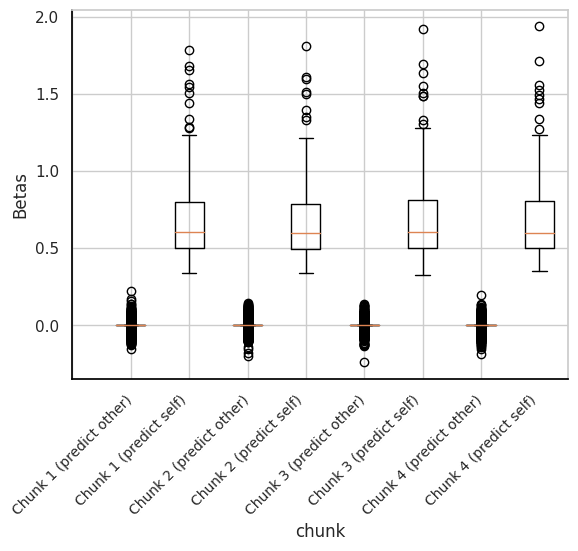

In [95]:
# Create an empty list to store the combined data for plotting
combined_data = []

# Iterate over each row in 'non_diagonal_elements' and corresponding row in 'static_betas_mean_self_predict'
for i in range(n_chunk):
    # Add the first 105300 values from 'non_diagonal_elements'
    non_diagonal_elements_clean = non_diagonal_elements[i][~np.isnan(non_diagonal_elements[i])]
    combined_data.append(non_diagonal_elements_clean)
    # Add the corresponding row from 'static_betas_mean_self_predict'
    static_betas_mean_self_predict_clean = static_betas_mean_self_predict[i][~np.isnan(static_betas_mean_self_predict[i])]
    combined_data.append(static_betas_mean_self_predict_clean)

# Create a boxplot

plt.boxplot(combined_data)

# Set labels for x-axis ticks
if n_chunk == 4:
    labels = ['Chunk 1 (predict other)', 'Chunk 1 (predict self)', 'Chunk 2 (predict other)', 'Chunk 2 (predict self)', 
                                'Chunk 3 (predict other)', 'Chunk 3 (predict self)', 'Chunk 4 (predict other)', 'Chunk 4 (predict self)']
elif n_chunk == 12:
    labels = ['1 (other)', '1 (self)', '2 (other)', '2 (self)', 
              '3 (other)', '3 (self)', '4 (other)', '4 (self)',
              '5 (other)', '5 (self)', '6 (other)', '6 (self)', 
              '7 (other)', '7 (self)', '8 (other)', '8 (self)',
              '9 (other)', '9 (self)', '10 (other)', '10 (self)', 
              '11 (other)', '11 (self)', '12 (other)', '12 (self)']

plt.xticks(np.arange(1, 2*n_chunk+1)-1, labels, fontsize=10)

plt.xticks(rotation=45)

# Set labels for y-axis and title
plt.ylabel('Betas')
plt.xlabel('chunk')
#plt.title('Boxplot of Non-Diagonal Elements and Static Betas')

# Set the color of the spines to black
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

# Show the plot
plt.show()